In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import json


# VEST RI 2018

Note: This notebook performs only election data validation

In [2]:
STATE_NAME = 'ri'
STATE_YEAR = '2018'

#### Functions used

1. allocating votes

In [3]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

2. precinct level validation

In [4]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

3. state level validation

In [5]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

4. county level validation

In [6]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

## VEST's Documentation File

### Sources

Election results from Rhode Island Board of Elections (https://www.ri.gov/election/results/2016/general_election/data/)

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. (not applicable)

### Processing

Election data processing:
   - Limited ballots were reported by township. 
   - Federal ballots were reported by congressional district. These were distributed by candidate to precincts based on their share of the precinct-level vote for the given reporting unit.


Shapefile processing (non applicable):
- Several precincts in Providence were aligned with the city ward shapefile. 

### Candidates

#### U.S. Senate - USS

- G18USSDWHI - Sheldon Whitehouse (Democratic Party)
- G18USSRFLA - Robert G. Flanders Jr. (Republican Party)
- G18USSOWRI - Write-in Votes

#### Governor - GOV

- G18GOVDRAI - Gina M. Raimondo (Democratic Party)
- G18GOVRFUN - Allan W. Fung (Republican Party)
- G18GOVITRI - Joseph A. Trillo (Independent)
- G18GOVIMUN - Luis-Daniel Mu�oz (Independent)
- G18GOVOGIL - William H. Gilbert (Moderate Party)
- G18GOVOARM - Anne Armstrong (Compassion Party)
- G18GOVOWRI - Write-in Votes

#### Lieutenant Governor - LTG

- G18LTGDMCK - Daniel J. McKee (Democratic Party)
- G18LTGRPEN - Paul E. Pence (Republican Party)
- G18LTGIRIC - Jonathan J. Riccitelli (Independent)
- G18LTGIMCC - Ross K. McCurdy (Independent)
- G18LTGOHEL - Joel J. Hellmann (Moderate Party)
- G18LTCOWRI - Write-in Votes

Note: Error in documentation, Write-In votes are recorded as G18 LTC OWRI, as opposed to G18 LTG OWRTI, with a G potentially mistaken for a C

#### Attorney General - ATG

- G18ATGDNER - Peter F. Neronha (Democratic Party)
- G18ATGOGOR - Alan Gordon (Compassion Party)
- G18ATGOWRI - Write-in Votes

#### Treasurer - TRE

- G18TREDMAG - Seth Magaziner (Democratic Party)
- G18TRERRIL - Michael G. Riley (Republican Party)
- G18TREOWRI - Write-in Votes

#### Secretary of State - SOS

- G18SOSDGOR - Nellie M. Gorbea (Democratic Party)
- G18SOSRCOR - Pat V. Cortellessa (Republican Party)
- G18SOSOWRI - Write-in Votes

In [7]:
races = [
    #U.S. Senate
    'G18USSDWHI',
    'G18USSRFLA',
    'G18USSOWRI',

    # Governor
    'G18GOVDRAI',
    'G18GOVRFUN',
    'G18GOVITRI',
    'G18GOVIMUN',
    'G18GOVOGIL',
    'G18GOVOARM',
    'G18GOVOWRI',

    #Lieutenant Governor
    'G18LTGDMCK',
    'G18LTGRPEN',
    'G18LTGIRIC',
    'G18LTGIMCC',
    'G18LTGOHEL',
    'G18LTGOWRI', #LTC -> LTG error fixed 

    # Attorney General
    'G18ATGDNER',
    'G18ATGOGOR',
    'G18ATGOWRI',

    #Treasure
    'G18TREDMAG',
    'G18TRERRIL',
    'G18TREOWRI',

    # Secretary of State
    'G18SOSDGOR',
    'G18SOSRCOR',
    'G18SOSOWRI'
]

## Load in VEST file

In [8]:
state_name_year = STATE_NAME + '_' + STATE_YEAR
path_to_vest_file = 'raw-from-source/VEST/' + state_name_year + '/' + state_name_year + '.shp'
vest = gp.read_file(path_to_vest_file)

In [9]:
vest.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

<AxesSubplot:>

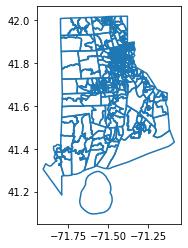

In [10]:
vest.boundary.plot()

In [11]:
vest.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G18USSDWHI',
       'G18USSRFLA', 'G18USSOWRI', 'G18GOVDRAI', 'G18GOVRFUN', 'G18GOVITRI',
       'G18GOVIMUN', 'G18GOVOGIL', 'G18GOVOARM', 'G18GOVOWRI', 'G18LTGDMCK',
       'G18LTGRPEN', 'G18LTGIRIC', 'G18LTGIMCC', 'G18LTGOHEL', 'G18LTGOWRI',
       'G18ATGDNER', 'G18ATGOGOR', 'G18ATGOWRI', 'G18TREDMAG', 'G18TRERRIL',
       'G18TREOWRI', 'G18SOSDGOR', 'G18SOSRCOR', 'G18SOSOWRI', 'geometry'],
      dtype='object')

In [12]:
vest.head(5)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G18USSDWHI,G18USSRFLA,G18USSOWRI,G18GOVDRAI,G18GOVRFUN,...,G18ATGDNER,G18ATGOGOR,G18ATGOWRI,G18TREDMAG,G18TRERRIL,G18TREOWRI,G18SOSDGOR,G18SOSRCOR,G18SOSOWRI,geometry
0,44,009,443208,44009443208,South Kingstown 8,1120,724,4,1040,611,...,1334,301,15,1144,643,0,1198,586,2,"POLYGON ((-71.60673 41.41403, -71.60623 41.415..."
1,44,007,440724,44007440724,Cranston 24,1024,281,3,912,309,...,1085,116,16,1005,275,2,1058,224,2,"POLYGON ((-71.40395 41.77325, -71.40316 41.774..."
2,44,005,ZZZZZZ,44005ZZZZZZ,Voting Districts Not Defined,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-71.50944 41.30773, -71.50660 41.312..."
3,44,005,441501,44005441501,JAMESTOWN 1,1091,552,3,1024,459,...,1421,116,13,1102,479,1,1138,457,1,"POLYGON ((-71.38543 41.55423, -71.38534 41.554..."
4,44,005,441502,44005441502,JAMESTOWN 2,1084,534,3,947,513,...,1349,157,14,1074,493,2,1114,459,1,"POLYGON ((-71.42190 41.44900, -71.41727 41.455..."


In [13]:
vest.shape

(423, 31)

In [14]:
vest.STATEFP20.unique()

array(['44'], dtype=object)

make sure VTDST20 is a unique column

In [15]:
assert(len(vest['VTDST20']) == len(vest['VTDST20'].unique()))

Note: VTDST20 is a combination of two digit STATEFP20 (44) and the unique Precinct ID used by the source file

## Election Results

### Load, Clean, Pivot Election Results

In [16]:
source_filepath = 'raw-from-source/Election_Results/rigen2018l.asc'

Using non-standard method of importing due to the format of the file (.asc)

In [17]:
with open(source_filepath) as f:
    values = []
    for idx, line in enumerate(f):
        data = line.split('  ')
        data = list(filter(None, data))
        values.append(data)
    raw_df = pd.DataFrame(values)

create source race number to race name used by VEST

In [18]:
race_num_to_name = {
    '0301': 'USS',
    '0304': 'GOV',
    '0305': 'LTG',
    '0306': 'SOS',
    '0307': 'ATG',
    '0308': 'TRE'
}

isolate senator race due to different column naming

In [19]:
senator_df = pd.DataFrame()
senator_df['race_num'] = raw_df[0].apply(lambda x: x[:4])
senator_df['race_name'] = senator_df['race_num'].map(race_num_to_name)

senator_df['candidate'] = raw_df[0].apply(lambda x: x[4:7])
senator_df['candidate_name'] = raw_df[2]

senator_df['precinct'] = raw_df[0].apply(lambda x: x[7:11])
senator_df['precinct_name'] = raw_df[3]

senator_df['votes'] = raw_df[0].apply(lambda x: x[11:17]).astype(int)
senator_df = senator_df[senator_df['race_name'] == 'USS']

display(senator_df)


,race_num,race_name,candidate,candidate_name,precinct,precinct_name,votes
0,0301,USS,001,Sheldon Whitehouse,0101,Barrington 0101,922
1,0301,USS,001,Sheldon Whitehouse,0102,Barrington 0102,1255
2,0301,USS,001,Sheldon Whitehouse,0103,Barrington 0103,999
3,0301,USS,001,Sheldon Whitehouse,0104,Barrington 0104,1192
4,0301,USS,001,Sheldon Whitehouse,0105,Barrington 0105,1200
...,...,...,...,...,...,...,...
1384,0301,USS,003,WRITE-IN,3911,Woonsocket 3911,1
1385,0301,USS,003,WRITE-IN,3912,Woonsocket 3912,0
1386,0301,USS,003,WRITE-IN,3913,Woonsocket Limited,0
1387,0301,USS,003,WRITE-IN,9001,Federal Precinct #1,0


Clean the resulting dataframe due to the following two issues:
- Providence Limited is not split correctly into Providence and Limited to produce a correct county name - due to Providence Limited votes split into 2

In [20]:
senator_df['township'] = senator_df['precinct_name'].apply(lambda x: x.rsplit(' ', 1)[0])
senator_df['township'] = senator_df['township'].apply(lambda x: x.strip())
senator_df['township'] = senator_df['township'].replace({'Providence Limited': 'Providence'})

Create dictionaries to translate from id to township and from id to precinct name, to be used for vote allocation and validation

In [21]:
id_to_township = senator_df[['precinct', 'township']]
id_to_township_dict = dict(id_to_township.values)
id_to_name = senator_df[['precinct', 'precinct_name']]
id_to_name_dict = dict(id_to_name.values)

isolate non senator races

In [22]:
other_race_list = ['GOV','LTG','SOS','ATG','TRE']

race_df = pd.DataFrame()
race_df['race_num'] = raw_df[0].apply(lambda x: x[:4])
race_df['race_name'] = race_df['race_num'].map(race_num_to_name)

race_df['candidate'] = raw_df[0].apply(lambda x: x[4:7])
race_df['candidate_name'] = raw_df[1]

race_df['precinct'] = raw_df[0].apply(lambda x: x[7:11])
race_df['precinct_name'] = raw_df[2]

race_df['votes'] = raw_df[0].apply(lambda x: x[11:17]).astype(int)

race_df = race_df[race_df['race_name'].isin(other_race_list)]
race_df

,race_num,race_name,candidate,candidate_name,precinct,precinct_name,votes
2778,0304,GOV,001,Gina M. Raimondo,0101,Barrington 0101,862
2779,0304,GOV,001,Gina M. Raimondo,0102,Barrington 0102,1163
2780,0304,GOV,001,Gina M. Raimondo,0103,Barrington 0103,1046
2781,0304,GOV,001,Gina M. Raimondo,0104,Barrington 0104,1125
2782,0304,GOV,001,Gina M. Raimondo,0105,Barrington 0105,1180
...,...,...,...,...,...,...,...
12915,0308,TRE,003,WRITE-IN,3909,Woonsocket 3909,0
12916,0308,TRE,003,WRITE-IN,3910,Woonsocket 3910,2
12917,0308,TRE,003,WRITE-IN,3911,Woonsocket 3911,3
12918,0308,TRE,003,WRITE-IN,3912,Woonsocket 3912,1


Combine both dataframes

In [23]:
del senator_df['township']
pre_pivot = pd.concat([senator_df, race_df])

Create a new column that combines race number and candidate number to create unique columns in final dataframe

In [24]:
pre_pivot['race_cand'] = pre_pivot['race_num'] + pre_pivot['candidate']

Create a dictionary that translates from race_cand column to VEST race name

In [25]:
race_cand_to_code_dict = {
    #U.S. Senate
    '0301001': 'G18USSDWHI',
    '0301002': 'G18USSRFLA',
    '0301003': 'G18USSOWRI',

    # Governor
    '0304001': 'G18GOVDRAI',
    '0304003': 'G18GOVRFUN',
    '0304006': 'G18GOVITRI',
    '0304005': 'G18GOVIMUN',
    '0304002': 'G18GOVOGIL',
    '0304004': 'G18GOVOARM',
    '0304007': 'G18GOVOWRI',

    #Lieutenant Governor
    '0305001': 'G18LTGDMCK',
    '0305003': 'G18LTGRPEN',
    '0305004': 'G18LTGIRIC',
    '0305005': 'G18LTGIMCC',
    '0305002': 'G18LTGOHEL',
    '0305006': 'G18LTGOWRI', #LTC -> LTG error fixed 

    # Attorney General
    '0307001': 'G18ATGDNER',
    '0307002': 'G18ATGOGOR',
    '0307003': 'G18ATGOWRI',

    #Treasure
    '0308001': 'G18TREDMAG',
    '0308002': 'G18TRERRIL',
    '0308003': 'G18TREOWRI',

    # Secretary of State
    '0306001': 'G18SOSDGOR',
    '0306002': 'G18SOSRCOR',
    '0306003': 'G18SOSOWRI'
}

#### Perform the pivot

In [26]:
pivoted = pd.pivot_table(pre_pivot,values=["votes"],index=["precinct"],columns=["race_cand"],aggfunc=sum)
pivoted=pivoted.fillna(0)
pivoted.reset_index(drop=False,inplace=True)
pivoted.columns = pivoted.columns.droplevel(0)


Use source race code and cand name field to map to VEST race codes

In [27]:
pivoted.columns = pivoted.columns.map(race_cand_to_code_dict)
cols = pivoted.columns.to_list()
del cols[0]
cols = ['precinctid'] + cols
pivoted.columns = cols
display(pivoted)


,precinctid,G18USSDWHI,G18USSRFLA,G18USSOWRI,G18GOVDRAI,G18GOVOGIL,G18GOVRFUN,G18GOVOARM,G18GOVIMUN,G18GOVITRI,...,G18LTGOWRI,G18SOSDGOR,G18SOSRCOR,G18SOSOWRI,G18ATGDNER,G18ATGOGOR,G18ATGOWRI,G18TREDMAG,G18TRERRIL,G18TREOWRI
0,0101,922.0,491.0,5.0,862.0,32.0,430.0,14.0,21.0,56.0,...,13.0,986.0,401.0,1.0,1094.0,182.0,14.0,950.0,439.0,1.0
1,0102,1255.0,566.0,3.0,1163.0,35.0,502.0,20.0,20.0,73.0,...,18.0,1313.0,471.0,2.0,1418.0,244.0,11.0,1281.0,505.0,3.0
2,0103,999.0,481.0,5.0,1046.0,25.0,361.0,6.0,8.0,33.0,...,14.0,1061.0,391.0,1.0,1186.0,143.0,19.0,1048.0,413.0,0.0
3,0104,1192.0,564.0,5.0,1125.0,48.0,501.0,11.0,18.0,50.0,...,18.0,1251.0,468.0,2.0,1395.0,186.0,11.0,1240.0,486.0,0.0
4,0105,1200.0,594.0,3.0,1180.0,37.0,476.0,18.0,17.0,54.0,...,36.0,1264.0,491.0,2.0,1381.0,216.0,21.0,1233.0,529.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,3911,559.0,326.0,1.0,520.0,10.0,298.0,17.0,13.0,32.0,...,3.0,565.0,296.0,1.0,628.0,184.0,9.0,548.0,292.0,3.0
459,3912,483.0,343.0,0.0,405.0,26.0,322.0,15.0,16.0,42.0,...,0.0,510.0,293.0,0.0,566.0,175.0,3.0,508.0,287.0,1.0
460,3913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
461,9001,77.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Use previously created dictionaries to create columns for township and precinct_name

In [28]:
pivoted['township'] = pivoted['precinctid'].map(id_to_township_dict)
pivoted['precinct_name'] = pivoted['precinctid'].map(id_to_name_dict)


Isolate federal level votes for later distribution

In [29]:
non_federal_df = pivoted[pivoted.township != 'Federal Precinct']
federal_df = pivoted[pivoted.township == 'Federal Precinct']

#### Perform statewide election data validation

In [30]:
statewide_totals_check(vest,pivoted,races)

***Statewide Totals Check***
G18USSDWHI is equal 	VEST / RDH: 231477
G18USSRFLA is equal 	VEST / RDH: 144421
G18USSOWRI is equal 	VEST / RDH: 840
G18GOVDRAI is equal 	VEST / RDH: 198122
G18GOVRFUN is equal 	VEST / RDH: 139932
G18GOVITRI is equal 	VEST / RDH: 16532
G18GOVIMUN is equal 	VEST / RDH: 6223
G18GOVOGIL is equal 	VEST / RDH: 10155
G18GOVOARM is equal 	VEST / RDH: 4191
G18GOVOWRI is equal 	VEST / RDH: 1246
G18LTGDMCK is equal 	VEST / RDH: 226528
G18LTGRPEN is equal 	VEST / RDH: 106505
G18LTGIRIC is equal 	VEST / RDH: 9866
G18LTGIMCC is equal 	VEST / RDH: 9408
G18LTGOHEL is equal 	VEST / RDH: 11332
G18LTGOWRI is equal 	VEST / RDH: 2513
G18ATGDNER is equal 	VEST / RDH: 274350
G18ATGOGOR is equal 	VEST / RDH: 65674
G18ATGOWRI is equal 	VEST / RDH: 3657
G18TREDMAG is equal 	VEST / RDH: 237575
G18TRERRIL is equal 	VEST / RDH: 127944
G18TREOWRI is equal 	VEST / RDH: 539
G18SOSDGOR is equal 	VEST / RDH: 247276
G18SOSRCOR is equal 	VEST / RDH: 119293
G18SOSOWRI is equal 	VEST / RDH: 54

Township-by-township election data validation is performed after vote allocation (due to federal level vote distribution)

### Distribute federal and township level votes

Township-level distribution first results in 28 precincts being off by 1, while federal-level distribution first results in 34 - therefore the former is preferred

#### Distribute township-level votes

Separate township-level and precinct-level votes into two dataframes

In [31]:
townshipwide = non_federal_df[non_federal_df['precinct_name'].str.contains('Presidential|Limited')]
non_townshipwide = non_federal_df.drop(townshipwide.index)

Perform the distribution

In [32]:
pre_fed_dist = allocate_absentee(non_townshipwide,townshipwide,races,'township')

#### Distribute federal-level votes

In [33]:
federal_df

,precinctid,G18USSDWHI,G18USSRFLA,G18USSOWRI,G18GOVDRAI,G18GOVOGIL,G18GOVRFUN,G18GOVOARM,G18GOVIMUN,G18GOVITRI,...,G18SOSRCOR,G18SOSOWRI,G18ATGDNER,G18ATGOGOR,G18ATGOWRI,G18TREDMAG,G18TRERRIL,G18TREOWRI,township,precinct_name
461,9001,77.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Federal Precinct,Federal Precinct #1
462,9002,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Federal Precinct,Federal Precinct #2


Isolate Congress Representative election data 

In [34]:
rep_df = raw_df[raw_df[0].str.contains('Representative in Congress District')]

Create a dataframe that contains precinct id and district number:
- chars in position 108-111 correspond with district number
- 0030 refers to district 1, while 0031 refers to district 2

In [35]:
district_df = pd.DataFrame()
district_df['precinct'] = rep_df[0].apply(lambda x: x[7:11])
district_df['district'] = rep_df[0].apply(lambda x: x[107:111])
district_df['district'] = district_df['district'].replace({'0030': '1'})
district_df['district'] = district_df['district'].replace({'0031': '2'})


Convert the df into a dictionary to be used for vote distribution

In [36]:
id_to_district_dict = dict(district_df.values)

Create a district column in both precinct-level and federal-level dfs

In [37]:
pre_fed_dist['district'] = pre_fed_dist['precinctid'].map(id_to_district_dict)
federal_df['district'] = federal_df['precinctid'].map(id_to_district_dict)

<ipython-input-37-38a12efbbf88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_fed_dist['district'] = pre_fed_dist['precinctid'].map(id_to_district_dict)
<ipython-input-37-38a12efbbf88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  federal_df['district'] = federal_df['precinctid'].map(id_to_district_dict)


Perform the distribution

In [38]:
source = allocate_absentee(pre_fed_dist,federal_df,races,'district')

/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy 

#### Perform township level election data validation

Create a township column in vest df using names of precincts

In [39]:
vest['township'] = vest['NAME20'].apply(lambda x: x.rsplit(' ', 1)[0].title())

Filter out township not present in source (which has zero votes and is not an official township)

In [40]:
vest_filter_township = vest[vest['township'] != 'Voting Districts Not']

In [41]:
display(vest[vest['township'] == 'Voting Districts Not'])

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G18USSDWHI,G18USSRFLA,G18USSOWRI,G18GOVDRAI,G18GOVRFUN,...,G18ATGOGOR,G18ATGOWRI,G18TREDMAG,G18TRERRIL,G18TREOWRI,G18SOSDGOR,G18SOSRCOR,G18SOSOWRI,geometry,township
2,44,005,ZZZZZZ,44005ZZZZZZ,Voting Districts Not Defined,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-71.50944 41.30773, -71.50660 41.312...",Voting Districts Not


Check vote totals

In [42]:
county_totals_check(vest_filter_township,source,races,'township',full_print=False)

***Countywide Totals Check***

G18USSDWHI contains differences in these counties:
	Providence has a difference of 1.0 votes
		VEST: 36648 votes
		SOURCES: 36647.0 votes
	Warwick has a difference of -1.0 votes
		VEST: 19516 votes
		SOURCES: 19517.0 votes
G18USSRFLA is equal across all counties
G18USSOWRI is equal across all counties
G18GOVDRAI is equal across all counties
G18GOVRFUN is equal across all counties
G18GOVITRI is equal across all counties
G18GOVIMUN is equal across all counties
G18GOVOGIL is equal across all counties
G18GOVOARM is equal across all counties
G18GOVOWRI is equal across all counties
G18LTGDMCK is equal across all counties
G18LTGRPEN is equal across all counties
G18LTGIRIC is equal across all counties
G18LTGIMCC is equal across all counties
G18LTGOHEL is equal across all counties
G18LTGOWRI is equal across all counties
G18ATGDNER is equal across all counties
G18ATGOGOR is equal across all counties
G18ATGOWRI is equal across all counties
G18TREDMAG is equal across

### Merge Source and VEST df

Create a joinid field

In [43]:
vest['joinid'] = vest['VTDST20']
source['joinid'] = vest.STATEFP20.unique()[0] + source['precinctid'].astype(str)

<ipython-input-43-2cd22a1bd623>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['joinid'] = vest.STATEFP20.unique()[0] + source['precinctid'].astype(str)


Perform the merge

In [44]:
join_attempt = pd.merge(vest,source,how="outer",on="joinid",indicator=True)
print(join_attempt["_merge"].value_counts())


merged = join_attempt[join_attempt["_merge"]=="both"]
right_only = join_attempt[join_attempt["_merge"]=="right_only"]
left_only = join_attempt[join_attempt["_merge"]=="left_only"]

left_only.to_csv('./left_only.csv')

both          421
left_only       2
right_only      0
Name: _merge, dtype: int64


Ensure non-merged precincts are zero-vote
- Since left_only didn't merge, we'll be checking if any race_x votes are non_zero

In [45]:
data_columns = races
empty_precincts = []
for index, row in left_only.iterrows():
    number_of_zero_races = 0
    for race in data_columns:
        if (row[race + '_x']==0):
            number_of_zero_races+= 1
    if(number_of_zero_races == len(data_columns)):
        empty_precincts.append(row["joinid"])
print(len(empty_precincts))
assert(len(empty_precincts) == len(left_only))

2


Perform precinct-level validation

In [46]:
precinct_votes_check(merged,races,True,'joinid',print_level=0)


G18USSDWHI ..................................................................442803 (V) .1056  (S).1057 (D):   -1
G18GOVDRAI ..................................................................442803 (V) .1054  (S).1055 (D):   -1
G18ATGDNER ..................................................................442803 (V) .1077  (S).1078 (D):   -1
G18TREDMAG ..................................................................442803 (V) .1048  (S).1049 (D):   -1
G18SOSDGOR ..................................................................442803 (V) .1076  (S).1077 (D):   -1
G18USSDWHI ..................................................................442805 (V) .1476  (S).1477 (D):   -1
G18GOVDRAI ..................................................................442805 (V) .1442  (S).1443 (D):   -1
G18LTGDMCK ..................................................................442805 (V) .1340  (S).1341 (D):   -1
G18ATGDNER ..................................................................442805 (V) 